In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

In [2]:
def import_from_files():
    """
        Read .csv files and store data into an array
        format: |NLOS|Measured range|FP_IDX|FP_AMP1|FP_AMP2|FP_AMP3|STDEV_NOISE|CIR_PWR|MAX_NOISE|RXPACC|CH|FRAME_LEN|PREAM_LEN|BITRATE|PRFR|CIR...|
    """
    rootdir = '/content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset'
    output_arr = []
    first = 1
    for dirpath, dirnames, filenames in os.walk(rootdir):
        for file in filenames:
            filename = os.path.join(dirpath, file)
            print(f"Processing file: {filename}")
            df = pd.read_csv(filename, sep=',', header=0)
            input_data = df.values

            if first > 0:
                first = 0
                output_arr = input_data
            else:
                output_arr = np.vstack((output_arr, input_data))

    return output_arr

In [3]:
    # Import raw data from folder with dataset
    print("Importing dataset to numpy array")
    print("-------------------------------")
    data = import_from_files()
    print("-------------------------------")

    # Print dimensions and data
    print(f"Number of samples in dataset: {len(data)}")
    print(f"Length of one sample: {len(data[0])}")
    print("-------------------------------")
    print("Dataset Sample:")
    print(data[:5])  # Display the first 5 samples

Importing dataset to numpy array
-------------------------------
Processing file: /content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset/uwb_dataset_part3.csv
Processing file: /content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset/uwb_dataset_part1.csv
Processing file: /content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset/uwb_dataset_part4.csv
Processing file: /content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset/uwb_dataset_part7.csv
Processing file: /content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset/uwb_dataset_part2.csv
Processing file: /content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset/uwb_dataset_part5.csv
Processing file: /content/drive/MyDrive/Colab Notebooks/UWB-localization-master/data/NLOSClassification/dataset/uwb_dataset_part6.c

In [4]:
# Assign columns to variables
NLOS = data[:, 0]  # Target variable (1 if NLOS, 0 if LOS)
Measured_range = data[:, 1]
FP_IDX = data[:, 2]
FP_AMP1 = data[:, 3]
FP_AMP2 = data[:, 4]
FP_AMP3 = data[:, 5]
STDEV_NOISE = data[:, 6]
CIR_PWR = data[:, 7]
MAX_NOISE = data[:, 8]
RXPACC = data[:, 9]
CH = data[:, 10]
FRAME_LEN = data[:, 11]
PREAM_LEN = data[:, 12]
BITRATE = data[:, 13]
PRFR = data[:, 14]
CIR = data[:, 15:]  # Assuming the CIR is in the remaining columns

In [10]:
print(CIR)
len(CIR[0])

[[145. 208. 525. ... 477. 475. 512.]
 [238. 244. 181. ... 133. 178.   0.]
 [ 93. 238. 214. ... 251. 248.   0.]
 ...
 [  9. 283. 311. ... 257. 316.   0.]
 [216. 450. 159. ... 258. 244.   0.]
 [262. 432. 146. ...  78. 160.   0.]]


1016

In [12]:
# Extract the first 500 elements
first_500_elements = CIR[:499]

# Compute the sum of the squares of the first 500 elements
sum_of_squares = np.sum(np.square(first_500_elements))

# Divide the sum of squares by 500
result = sum_of_squares / 500

print("The result is:", result)

The result is: 1462294548.502


In [ ]:
 # Combine all features into two inputs
X1 = np.column_stack((FP_IDX, FP_AMP1, FP_AMP2, FP_AMP3, STDEV_NOISE, CIR_PWR, MAX_NOISE, RXPACC, CH, FRAME_LEN, PREAM_LEN, BITRATE, PRFR))
X2 = np.column_stack((Measured_range, CIR))  # Use CIR and measured distance the second input

y = NLOS  # Target variable

# Split the data into training and testing sets
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

# Scale the input data
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
X1_train = scaler_1.fit_transform(X1_train)
X2_train = scaler_2.fit_transform(X2_train)
X1_test = scaler_1.transform(X1_test)
X2_test = scaler_2.transform(X2_test)


In [ ]:
# First Input and Model Branch
input_1 = Input(shape=(13,))  # 14 features in X1
dense_1 = Dense(128, activation='relu')(input_1)
dense_2 = Dense(64, activation='relu')(dense_1)

# Second Input and Model Branch
input_2 = Input(shape=(len(CIR[0])+1,))
reshape_2 = Reshape((len(CIR[0])+1, 1))(input_2)

conv1_1 = Conv1D(64, kernel_size=3, activation='relu')(reshape_2)
max_pool_1 = MaxPooling1D(pool_size=2)(conv1_1)

conv1_2 = Conv1D(128, kernel_size=3, activation='relu')(max_pool_1)
max_pool_2 = MaxPooling1D(pool_size=2)(conv1_2)

flatten_1 = tf.keras.layers.Flatten()(max_pool_2)

# Concatenate both branches
concatenated = Concatenate()([dense_2, flatten_1])

# Final Dense Layers
output = Dense(1, activation='sigmoid')(concatenated)

In [ ]:
# Build and compile the model
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model and store training history
history = model.fit([X1_train, X2_train], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8389 - loss: 0.3775 - val_accuracy: 0.8810 - val_loss: 0.2926
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8763 - loss: 0.2927 - val_accuracy: 0.8790 - val_loss: 0.2928
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8809 - loss: 0.2810 - val_accuracy: 0.8826 - val_loss: 0.2876
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8953 - loss: 0.2500 - val_accuracy: 0.8751 - val_loss: 0.3058
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9123 - loss: 0.2130 - val_accuracy: 0.8640 - val_loss: 0.3418
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9256 - loss: 0.1837 - val_accuracy: 0.8604 - val_loss: 0.3591
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9402 - loss: 0.1539 - val_accuracy: 0.8585 - val_loss: 0.4192
Epoch 8/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9501 - loss: 0.1285 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate([X1_test, X2_test], y_test)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8513 - loss: 0.5470


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

Test Loss: 0.5645352602005005
Test Accuracy: 0.8455952405929565


In [ ]:
# Make predictions on the test set
y_pred = (model.predict([X1_test, X2_test]) > 0.5).astype(int)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
F1 Score: 0.8456136174264969


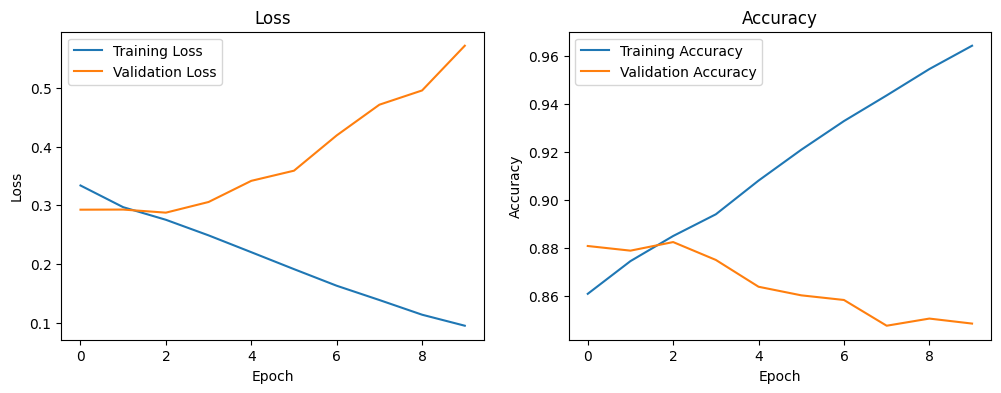

In [ ]:
# Plotting training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.show()